### System diagram
<img src="scheme.png" alt="drawing" width="50%"/>

### Imports

In [1]:
from typing import Iterable, List, Dict, Callable
import os
import gc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [3]:
PATH_TO_DATA = "c:/Hydraulics/data/"
NUMBER_OF_PROFILES = 2205
PROFILE_MAX_SAMPLE_RATE = 6000
TARGET_NAMES = ["cooler", "valve", "leakage", "accumulator", "stable"]

PLOT_STYLE = "darkgrid"

In [4]:
TARGET_VALUES_MAP = {
    "cooler": {
        3: "close to total failure",
        20: "reduced effifiency",
        100: "full efficiency",
    },
    "valve": {
        100:"optimal switching behavior",
        90: "small lag",
        80: "severe lag",
        73: "close to total failure",
    }, 
    "leakage": {
        0: "no",
	    1: "weak",
	    2: "severe",
    },
    "accumulator": {
        130: "optimal pressure",
    	115: "slightly reduced pressure",
	    100: "severely reduced pressure",
	    90:  "close to total failure",
     },
     "stable":{
        0: "yes",
	    1: "not",
     }
}

### Load data

In [5]:
sersor_files_config = [
    {"name": "CE", "upsample_coeff": 100},
    {"name": "CP", "upsample_coeff": 100},
    {"name": "EPS1", "upsample_coeff": 1},
    {"name": "FS1", "upsample_coeff": 10},
    {"name": "FS2", "upsample_coeff": 10},
    {"name": "PS1", "upsample_coeff": 1},
    {"name": "PS2", "upsample_coeff": 1},
    {"name": "PS3", "upsample_coeff": 1},
    {"name": "PS4", "upsample_coeff": 1},
    {"name": "PS5", "upsample_coeff": 1},
    {"name": "PS6", "upsample_coeff": 1},
    {"name": "SE", "upsample_coeff": 100},
    {"name": "TS1", "upsample_coeff": 100},
    {"name": "TS2", "upsample_coeff": 100},
    {"name": "TS3", "upsample_coeff": 100},
    {"name": "TS4", "upsample_coeff": 100},
    {"name": "VS1", "upsample_coeff": 100},
]

In [21]:
def get_files_with_resample(config: List[Dict]) -> Iterable[np.ndarray]:
    for file in config:
        data = np.genfromtxt(PATH_TO_DATA + file["name"] + ".txt", dtype=float, delimiter='\t')
        yield np.repeat(data, file["upsample_coeff"], axis=1).flatten()

In [22]:
def load_feature_dataframe(config: List[Dict]) -> pd.DataFrame:
    columns = [file["name"] for file in config]
    data = np.stack(get_files_with_resample(config), axis=-1)
    data_df = pd.DataFrame(data, columns=columns)

    prodile_ids = np.repeat(range(1, NUMBER_OF_PROFILES+1), PROFILE_MAX_SAMPLE_RATE)
    prodile_ids_df = pd.DataFrame(prodile_ids, columns=["profile_id"])

    return pd.concat([prodile_ids_df, data_df], axis=1, sort=False)   

In [23]:
def load_targets(filename: str) -> pd.DataFrame:
    conditions_data = np.genfromtxt(PATH_TO_DATA + filename, dtype=int, delimiter='\t')
    conditions_df = pd.DataFrame(conditions_data, columns=TARGET_NAMES)

    prodile_ids = range(1, NUMBER_OF_PROFILES+1)
    prodile_ids_df = pd.DataFrame(prodile_ids, columns=["profile_id"])

    return pd.concat([prodile_ids_df, conditions_df], axis=1, sort=False)   

In [24]:
feature_df = load_feature_dataframe(sersor_files_config)
target_df = load_targets("profile.txt") #Note that targets is define for profile, not to points

_ = gc.collect()

### EDA

In [25]:
feature_df.head()

,profile_id,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
0,1,47.202,2.184,2411.6,8.99,10.179,151.47,125.50,2.305,0.0,9.936,9.818,68.039,35.57,40.961,38.32,30.363,0.604
1,1,47.202,2.184,2411.6,8.99,10.179,151.45,125.39,2.305,0.0,9.947,9.823,68.039,35.57,40.961,38.32,30.363,0.604
2,1,47.202,2.184,2411.6,8.99,10.179,151.52,125.40,2.336,0.0,9.964,9.844,68.039,35.57,40.961,38.32,30.363,0.604
3,1,47.202,2.184,2411.6,8.99,10.179,151.27,125.03,2.578,0.0,9.989,9.861,68.039,35.57,40.961,38.32,30.363,0.604
4,1,47.202,2.184,2411.6,8.99,10.179,150.80,124.05,2.977,0.0,9.996,9.877,68.039,35.57,40.961,38.32,30.363,0.604


In [26]:
feature_df.tail()

,profile_id,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
13229995,2205,46.621,2.148,2416.2,7.774,10.176,151.64,125.73,2.305,10.204,9.989,9.870,68.117,35.426,40.891,38.187,30.375,0.531
13229996,2205,46.621,2.148,2416.6,7.774,10.176,151.70,125.81,2.320,10.238,10.007,9.882,68.117,35.426,40.891,38.187,30.375,0.531
13229997,2205,46.621,2.148,2416.8,7.774,10.176,151.73,125.77,2.273,10.223,10.007,9.886,68.117,35.426,40.891,38.187,30.375,0.531
13229998,2205,46.621,2.148,2417.0,7.774,10.176,151.71,125.66,2.227,10.218,9.988,9.870,68.117,35.426,40.891,38.187,30.375,0.531
13229999,2205,46.621,2.148,2417.0,7.774,10.176,151.70,125.77,2.250,10.212,9.964,9.854,68.117,35.426,40.891,38.187,30.375,0.531


In [27]:
target_df.head()

,profile_id,cooler,valve,leakage,accumulator,stable
0,1,3,100,0,130,1
1,2,3,100,0,130,1
2,3,3,100,0,130,1
3,4,3,100,0,130,1
4,5,3,100,0,130,1


In [28]:
target_df.tail()

,profile_id,cooler,valve,leakage,accumulator,stable
2200,2201,100,100,0,90,0
2201,2202,100,100,0,90,0
2202,2203,100,100,0,90,0
2203,2204,100,100,0,90,0
2204,2205,100,100,0,90,0


In [29]:
def generate_encoder(target_labels: Dict[str, Dict[int, str]], feature_name: str) -> Callable:
    encodes = target_labels[feature_name]

    def encode(value: int) -> str:
        return encodes[value]
    
    return encode

In [30]:
def plot_profile(df: pd.DataFrame, target_df: pd.DataFrame, profile_id: int, features: List[str] = []):
    filtered_df = df[features][df.profile_id == profile_id].reset_index()

    profile_target_values = target_df[target_df.profile_id == profile_id][TARGET_NAMES].to_dict("records")[0]
    profile_target_labels = [f"{k}: {generate_encoder(TARGET_VALUES_MAP, k)(v)}" for k, v in profile_target_values.items()]

    with sns.axes_style(PLOT_STYLE):
        figure, axes = plt.subplots(len(features), 1, figsize=(15, len(features)*2), sharex=True)
        figure.suptitle(f'{", ".join(profile_target_labels)}', fontsize=14)
        plt.xlabel("sample")

        for ax, feature_name in zip(axes, features):
            ax.plot(filtered_df[feature_name])
            ax.set_ylabel(feature_name)

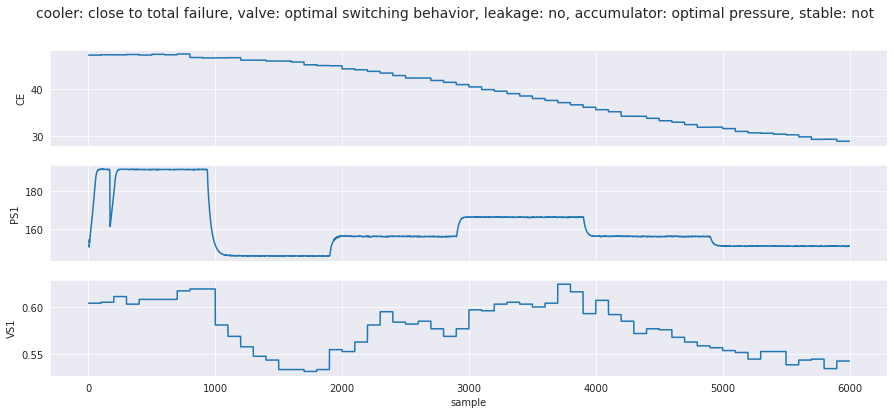

In [31]:
plot_profile(feature_df, profile_id=1, target_df=target_df, features=["CE", "PS1", "VS1"])

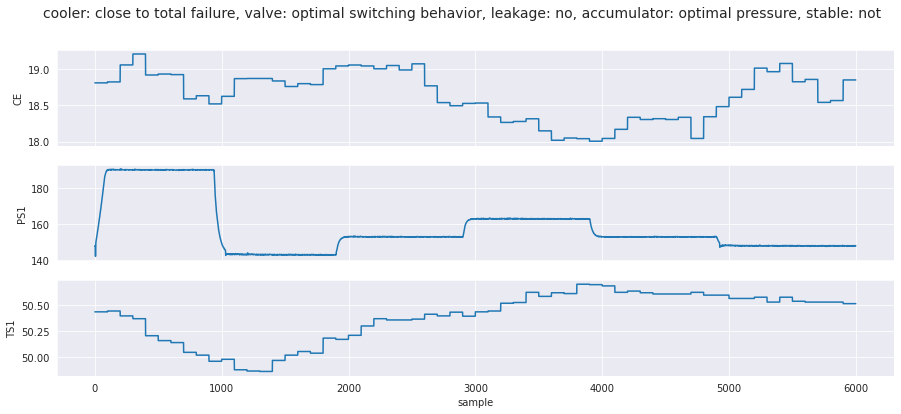

In [32]:
plot_profile(feature_df, profile_id=35, target_df=target_df, features=["CE", "PS1", "TS1"])

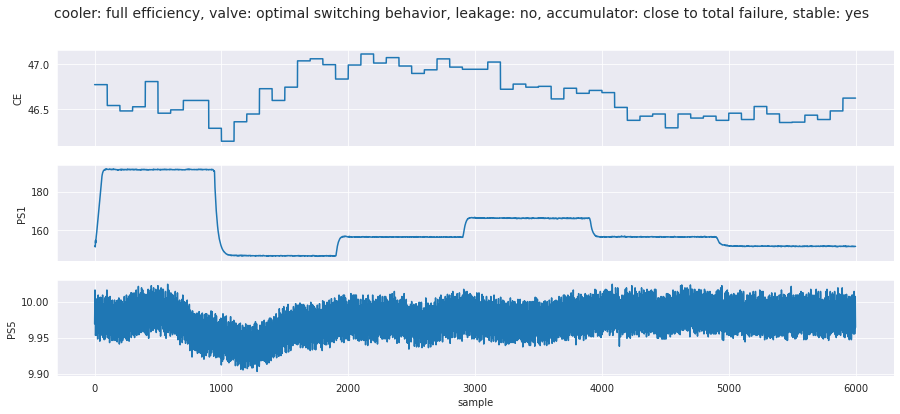

In [95]:
plot_profile(feature_df, profile_id=2205, target_df=target_df, features=["CE", "PS1", "PS5"])

In [93]:
def count_targets(df: pd.DataFrame):
    for target in TARGET_NAMES:
        encoder = generate_encoder(TARGET_VALUES_MAP, target)
        data = df[target].map(encoder)
        print(f"Distribution of '{target}' target:\n{data.value_counts()}\n")

In [94]:
count_targets(target_df) 

Distribution of 'cooler' target:
full efficiency           741
close to total failure    732
reduced effifiency        732
Name: cooler, dtype: int64

Distribution of 'valve' target:
optimal switching behavior    1125
severe lag                     360
close to total failure         360
small lag                      360
Name: valve, dtype: int64

Distribution of 'leakage' target:
no        1221
weak       492
severe     492
Name: leakage, dtype: int64

Distribution of 'accumulator' target:
close to total failure       808
optimal pressure             599
slightly reduced pressure    399
severely reduced pressure    399
Name: accumulator, dtype: int64

Distribution of 'stable' target:
yes    1449
not     756
Name: stable, dtype: int64

